In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
import json

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set_context("poster")

In [3]:
X_train = []
S_train = []
y_train = []

drives = ['V79_run_run_1.pkl', 'V79_run_run_2.pkl', 'V79_run_run_3.pkl', 'V79_run_run_4.pkl']
for drive in drives:
    with open('{}'.format(drive), 'rb') as f:
        data = pickle.load(f,encoding='latin1')
            
    X_train.extend(data['images'])
    S_train.extend(data['sensors']) #RPM, throttle
    y_train.extend(data['steering_throttle'].astype(np.float64))
    
    #flip left to right
    X_train.extend(np.array([np.fliplr(x) for x in data['images']]))
    S_train.extend(data['sensors']) #RPM, throttle
    y_train.extend(np.negative(data['steering_throttle'].astype(np.float64)))
    
X_train = np.array(X_train)
S_train = np.array(S_train)
y_train = np.array(y_train)[:,[0]]

In [4]:
print(X_train.shape, S_train.shape, y_train.shape)

(52070, 80, 320, 3) (52070, 2) (52070, 1)


In [5]:
#we want to predict the steering angle for the next second of video. Here we 
#skip each 3 frames and predict on them
num_predict_ahead_frames_to_use = 90
predict_ahead_step_rate = 3
num_predict_ahead_frames = num_predict_ahead_frames_to_use//predict_ahead_step_rate

In [6]:
# go through and create a vectors for look ahead, let try though 10
steering_buffer = list(y_train[:num_predict_ahead_frames_to_use])
print(len(steering_buffer))
yy_train = []

for y in y_train[num_predict_ahead_frames_to_use:]:
    yy_train.append(steering_buffer[::predict_ahead_step_rate])
    steering_buffer.append(y)
    steering_buffer = steering_buffer[1:]

90


In [7]:
X_train = X_train[:-num_predict_ahead_frames_to_use]
S_train = S_train[:-num_predict_ahead_frames_to_use]
y_train = y_train[:-num_predict_ahead_frames_to_use]
yy_train = np.array(yy_train)

In [8]:
print(X_train.shape, S_train.shape, yy_train.shape)

(51980, 80, 320, 3) (51980, 2) (51980, 30, 1)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


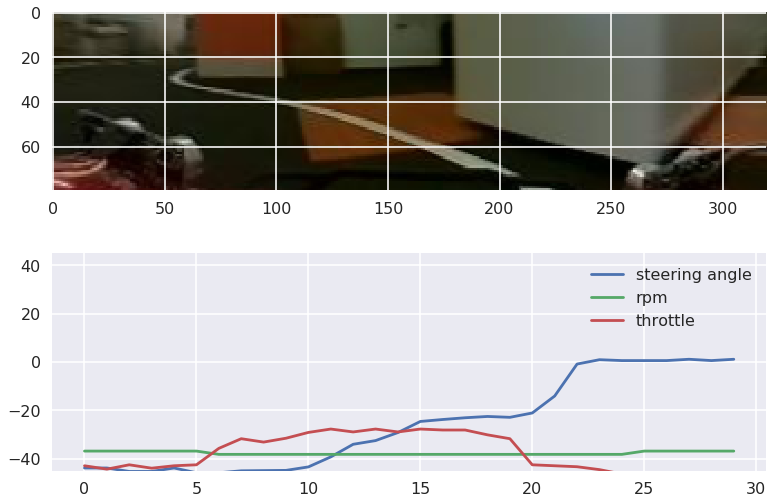

In [48]:
#view some images
frame = 220

plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(yy_train[frame] * 45, label="steering angle")
plt.plot(S_train[frame: frame + 90:3, 0] * 100 - 45, label="rpm")
plt.plot(S_train[frame: frame + 90:3, 1] * 100 - 45, label="throttle")
plt.ylim((-45,45))
plt.legend()
plt.show()


In [46]:
5000/50

100.0

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


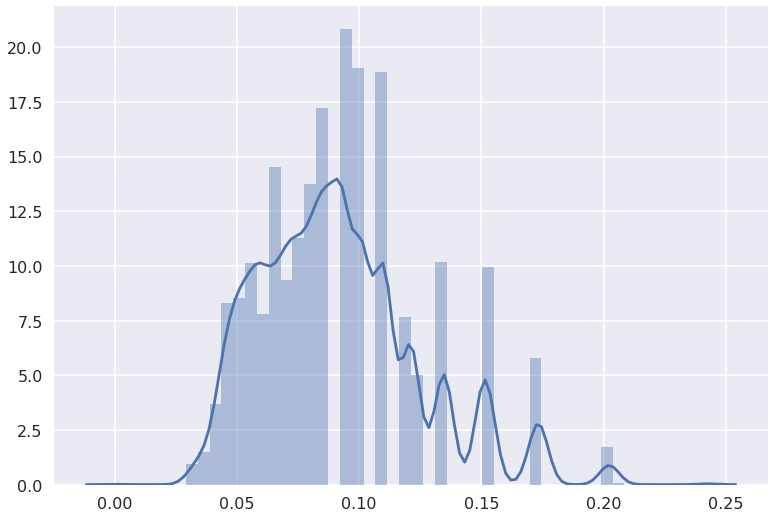

In [10]:
# lets look at the RPM data
sns.distplot(S_train[:,0])

In [11]:
def create_model():
    model = Sequential()
    
    #inputs
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(1,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3), name="lambda_1")(image_input)
    
    # conv1 layer
    X = Convolution2D(32, (5, 5), name="conv_1")(X)
    X = MaxPooling2D((2, 2), name="pool_1")(X)
    X = Activation('relu',name="relu_1")(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5), name="conv_2")(X)
    X = MaxPooling2D((3, 3), name="pool_2")(X)
    X = Activation('relu', name="relu_2")(X)
    
    # conv3 layer
    X = Convolution2D(128, (3, 3), name="conv_3")(X)
    X = MaxPooling2D((2, 2), name="pool_3")(X)
    X = Activation('relu', name="relu_3")(X)

    # conv4 layer
    X = Convolution2D(128, (3, 3), name="conv_4")(X)
    X = MaxPooling2D((2, 2), name="pool_4")(X)
    X = Activation('relu', name="relu_4")(X)

    #add fully connected layers
    X = Flatten(name="flat_1")(X)
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input], name="concate_1")
    
    # fc1
    X = Dense(1024, name="dnse_1")(X)
    X = Dropout(0.5, name="dropout_1")(X)
    X = Activation('relu', name="dense_relu_1")(X)
    
    # fc2
    X = Dense(128, name="dnse_2")(X)
    X = Dropout(0.5, name="dropout_2")(X)
    X = Activation('relu', name="dense_relu_2")(X)
    
    # fc2
    X = Dense(64, name="dnse_3")(X)
    X = Dropout(0.5, name="dropout_3")(X)
    X = Activation('relu', name="dense_relu_3")(X)
    
    #outputs are the next 10 frames
    steer_outputs = []
    for i in range(num_predict_ahead_frames):
        steer_output = Dense(1, name='steer_output_{}'.format(i))(X)
        steer_outputs.append(steer_output)
    
    

    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=steer_outputs)

    loss_def = {"steer_output_{}".format(i) : "mse" for i in range(num_predict_ahead_frames)}
    loss_weight_def = {"steer_output_{}".format(i) : 1.0 for i in range(num_predict_ahead_frames)}
    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam', loss=loss_def, loss_weights=loss_weight_def)

    return model

In [12]:
#create the model and save it as json
model = create_model()
with open("model.json", "w") as f:
    json.dump(model.to_json(), f)

In [13]:
#loading the model
from keras.models import model_from_json
with open("model.json") as f:
    model = model_from_json(json.load(f))
    model.compile(loss="mse", optimizer="adam")
#     model.load_weights("office_set_predict_ahead_90_2.h5")  #<--last run

In [14]:
y_output = {"steer_output_{}".format(i) : yy_train[:,i,:] for i in range(num_predict_ahead_frames)}

In [ ]:
hist = []
for i in range(0,30):
    print("{} --------------".format(i))
    h = model.fit({'image_input': X_train, 'sensor_input': S_train[:,0]},y_output, 
                  shuffle=True, epochs=5, validation_split=.3, batch_size=128)
    hist.append(h.history)
    with open('history.pkl', 'w') as f:
        json.dump(hist, f)
    model.save("office_set_predict_ahead_90_with_rpm_{}.h5".format(i))
    

0 --------------
Train on 36386 samples, validate on 15594 samples
Epoch 1/5
36386/36386 [==============================] - 124s - loss: 5.8017 - steer_output_0_loss: 0.2031 - steer_output_1_loss: 0.1977 - steer_output_2_loss: 0.1877 - steer_output_3_loss: 0.1898 - steer_output_4_loss: 0.1634 - steer_output_5_loss: 0.1676 - steer_output_6_loss: 0.1599 - steer_output_7_loss: 0.1535 - steer_output_8_loss: 0.1482 - steer_output_9_loss: 0.1635 - steer_output_10_loss: 0.1726 - steer_output_11_loss: 0.1506 - steer_output_12_loss: 0.1628 - steer_output_13_loss: 0.1525 - steer_output_14_loss: 0.1535 - steer_output_15_loss: 0.1728 - steer_output_16_loss: 0.1664 - steer_output_17_loss: 0.1750 - steer_output_18_loss: 0.1793 - steer_output_19_loss: 0.1891 - steer_output_20_loss: 0.2056 - steer_output_21_loss: 0.2193 - steer_output_22_loss: 0.2179 - steer_output_23_loss: 0.2202 - steer_output_24_loss: 0.2352 - steer_output_25_loss: 0.2376 - steer_output_26_loss: 0.2411 - steer_output_27_loss: 0.259

36386/36386 [==============================] - 119s - loss: 1.9311 - steer_output_0_loss: 0.0811 - steer_output_1_loss: 0.0711 - steer_output_2_loss: 0.0628 - steer_output_3_loss: 0.0566 - steer_output_4_loss: 0.0523 - steer_output_5_loss: 0.0503 - steer_output_6_loss: 0.0498 - steer_output_7_loss: 0.0505 - steer_output_8_loss: 0.0522 - steer_output_9_loss: 0.0542 - steer_output_10_loss: 0.0565 - steer_output_11_loss: 0.0580 - steer_output_12_loss: 0.0597 - steer_output_13_loss: 0.0606 - steer_output_14_loss: 0.0612 - steer_output_15_loss: 0.0614 - steer_output_16_loss: 0.0614 - steer_output_17_loss: 0.0612 - steer_output_18_loss: 0.0609 - steer_output_19_loss: 0.0606 - steer_output_20_loss: 0.0607 - steer_output_21_loss: 0.0612 - steer_output_22_loss: 0.0622 - steer_output_23_loss: 0.0639 - steer_output_24_loss: 0.0669 - steer_output_25_loss: 0.0715 - steer_output_26_loss: 0.0776 - steer_output_27_loss: 0.0854 - steer_output_28_loss: 0.0945 - steer_output_29_loss: 0.1048 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.7211 - steer_output_0_loss: 0.0710 - steer_output_1_loss: 0.0623 - steer_output_2_loss: 0.0559 - steer_output_3_loss: 0.0515 - steer_output_4_loss: 0.0490 - steer_output_5_loss: 0.0481 - steer_output_6_loss: 0.0483 - steer_output_7_loss: 0.0490 - steer_output_8_loss: 0.0500 - steer_output_9_loss: 0.0509 - steer_output_10_loss: 0.0516 - steer_output_11_loss: 0.0522 - steer_output_12_loss: 0.0525 - steer_output_13_loss: 0.0527 - steer_output_14_loss: 0.0529 - steer_output_15_loss: 0.0532 - steer_output_16_loss: 0.0537 - steer_output_17_loss: 0.0541 - steer_output_18_loss: 0.0545 - steer_output_19_loss: 0.0549 - steer_output_20_loss: 0.0552 - steer_output_21_loss: 0.0557 - steer_output_22_loss: 0.0563 - steer_output_23_loss: 0.0572 - steer_output_24_loss: 0.0590 - steer_output_25_loss: 0.0618 - steer_output_26_loss: 0.0663 - steer_output_27_loss: 0.0723 - steer_output_28_loss: 0.0799 - steer_output_29_loss: 0.0894 - val_loss: 1

36386/36386 [==============================] - 118s - loss: 1.6343 - steer_output_0_loss: 0.0689 - steer_output_1_loss: 0.0603 - steer_output_2_loss: 0.0540 - steer_output_3_loss: 0.0499 - steer_output_4_loss: 0.0478 - steer_output_5_loss: 0.0471 - steer_output_6_loss: 0.0472 - steer_output_7_loss: 0.0478 - steer_output_8_loss: 0.0486 - steer_output_9_loss: 0.0492 - steer_output_10_loss: 0.0495 - steer_output_11_loss: 0.0495 - steer_output_12_loss: 0.0493 - steer_output_13_loss: 0.0491 - steer_output_14_loss: 0.0491 - steer_output_15_loss: 0.0494 - steer_output_16_loss: 0.0500 - steer_output_17_loss: 0.0507 - steer_output_18_loss: 0.0515 - steer_output_19_loss: 0.0521 - steer_output_20_loss: 0.0527 - steer_output_21_loss: 0.0532 - steer_output_22_loss: 0.0536 - steer_output_23_loss: 0.0542 - steer_output_24_loss: 0.0555 - steer_output_25_loss: 0.0576 - steer_output_26_loss: 0.0613 - steer_output_27_loss: 0.0668 - steer_output_28_loss: 0.0744 - steer_output_29_loss: 0.0841 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.5634 - steer_output_0_loss: 0.0668 - steer_output_1_loss: 0.0582 - steer_output_2_loss: 0.0518 - steer_output_3_loss: 0.0478 - steer_output_4_loss: 0.0459 - steer_output_5_loss: 0.0454 - steer_output_6_loss: 0.0456 - steer_output_7_loss: 0.0464 - steer_output_8_loss: 0.0473 - steer_output_9_loss: 0.0482 - steer_output_10_loss: 0.0483 - steer_output_11_loss: 0.0481 - steer_output_12_loss: 0.0478 - steer_output_13_loss: 0.0474 - steer_output_14_loss: 0.0474 - steer_output_15_loss: 0.0477 - steer_output_16_loss: 0.0480 - steer_output_17_loss: 0.0486 - steer_output_18_loss: 0.0493 - steer_output_19_loss: 0.0500 - steer_output_20_loss: 0.0504 - steer_output_21_loss: 0.0508 - steer_output_22_loss: 0.0508 - steer_output_23_loss: 0.0511 - steer_output_24_loss: 0.0520 - steer_output_25_loss: 0.0539 - steer_output_26_loss: 0.0572 - steer_output_27_loss: 0.0625 - steer_output_28_loss: 0.0697 - steer_output_29_loss: 0.0791 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.5420 - steer_output_0_loss: 0.0665 - steer_output_1_loss: 0.0578 - steer_output_2_loss: 0.0514 - steer_output_3_loss: 0.0472 - steer_output_4_loss: 0.0454 - steer_output_5_loss: 0.0450 - steer_output_6_loss: 0.0453 - steer_output_7_loss: 0.0460 - steer_output_8_loss: 0.0466 - steer_output_9_loss: 0.0470 - steer_output_10_loss: 0.0472 - steer_output_11_loss: 0.0471 - steer_output_12_loss: 0.0470 - steer_output_13_loss: 0.0468 - steer_output_14_loss: 0.0467 - steer_output_15_loss: 0.0468 - steer_output_16_loss: 0.0472 - steer_output_17_loss: 0.0477 - steer_output_18_loss: 0.0484 - steer_output_19_loss: 0.0490 - steer_output_20_loss: 0.0495 - steer_output_21_loss: 0.0498 - steer_output_22_loss: 0.0501 - steer_output_23_loss: 0.0507 - steer_output_24_loss: 0.0514 - steer_output_25_loss: 0.0529 - steer_output_26_loss: 0.0561 - steer_output_27_loss: 0.0615 - steer_output_28_loss: 0.0691 - steer_output_29_loss: 0.0788 - val_loss: 1

36386/36386 [==============================] - 118s - loss: 1.5281 - steer_output_0_loss: 0.0658 - steer_output_1_loss: 0.0571 - steer_output_2_loss: 0.0508 - steer_output_3_loss: 0.0468 - steer_output_4_loss: 0.0450 - steer_output_5_loss: 0.0445 - steer_output_6_loss: 0.0449 - steer_output_7_loss: 0.0456 - steer_output_8_loss: 0.0464 - steer_output_9_loss: 0.0469 - steer_output_10_loss: 0.0470 - steer_output_11_loss: 0.0467 - steer_output_12_loss: 0.0461 - steer_output_13_loss: 0.0456 - steer_output_14_loss: 0.0456 - steer_output_15_loss: 0.0458 - steer_output_16_loss: 0.0465 - steer_output_17_loss: 0.0474 - steer_output_18_loss: 0.0484 - steer_output_19_loss: 0.0490 - steer_output_20_loss: 0.0496 - steer_output_21_loss: 0.0499 - steer_output_22_loss: 0.0501 - steer_output_23_loss: 0.0504 - steer_output_24_loss: 0.0512 - steer_output_25_loss: 0.0527 - steer_output_26_loss: 0.0557 - steer_output_27_loss: 0.0608 - steer_output_28_loss: 0.0681 - steer_output_29_loss: 0.0777 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.5340 - steer_output_0_loss: 0.0653 - steer_output_1_loss: 0.0568 - steer_output_2_loss: 0.0508 - steer_output_3_loss: 0.0469 - steer_output_4_loss: 0.0452 - steer_output_5_loss: 0.0449 - steer_output_6_loss: 0.0452 - steer_output_7_loss: 0.0457 - steer_output_8_loss: 0.0462 - steer_output_9_loss: 0.0465 - steer_output_10_loss: 0.0466 - steer_output_11_loss: 0.0465 - steer_output_12_loss: 0.0460 - steer_output_13_loss: 0.0458 - steer_output_14_loss: 0.0459 - steer_output_15_loss: 0.0462 - steer_output_16_loss: 0.0470 - steer_output_17_loss: 0.0478 - steer_output_18_loss: 0.0487 - steer_output_19_loss: 0.0495 - steer_output_20_loss: 0.0501 - steer_output_21_loss: 0.0503 - steer_output_22_loss: 0.0506 - steer_output_23_loss: 0.0510 - steer_output_24_loss: 0.0515 - steer_output_25_loss: 0.0530 - steer_output_26_loss: 0.0561 - steer_output_27_loss: 0.0612 - steer_output_28_loss: 0.0685 - steer_output_29_loss: 0.0784 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4777 - steer_output_0_loss: 0.0652 - steer_output_1_loss: 0.0563 - steer_output_2_loss: 0.0499 - steer_output_3_loss: 0.0459 - steer_output_4_loss: 0.0441 - steer_output_5_loss: 0.0435 - steer_output_6_loss: 0.0438 - steer_output_7_loss: 0.0443 - steer_output_8_loss: 0.0450 - steer_output_9_loss: 0.0454 - steer_output_10_loss: 0.0454 - steer_output_11_loss: 0.0452 - steer_output_12_loss: 0.0448 - steer_output_13_loss: 0.0444 - steer_output_14_loss: 0.0442 - steer_output_15_loss: 0.0443 - steer_output_16_loss: 0.0448 - steer_output_17_loss: 0.0457 - steer_output_18_loss: 0.0463 - steer_output_19_loss: 0.0469 - steer_output_20_loss: 0.0475 - steer_output_21_loss: 0.0479 - steer_output_22_loss: 0.0481 - steer_output_23_loss: 0.0484 - steer_output_24_loss: 0.0491 - steer_output_25_loss: 0.0503 - steer_output_26_loss: 0.0530 - steer_output_27_loss: 0.0580 - steer_output_28_loss: 0.0653 - steer_output_29_loss: 0.0749 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4675 - steer_output_0_loss: 0.0645 - steer_output_1_loss: 0.0557 - steer_output_2_loss: 0.0492 - steer_output_3_loss: 0.0452 - steer_output_4_loss: 0.0434 - steer_output_5_loss: 0.0432 - steer_output_6_loss: 0.0436 - steer_output_7_loss: 0.0446 - steer_output_8_loss: 0.0451 - steer_output_9_loss: 0.0456 - steer_output_10_loss: 0.0456 - steer_output_11_loss: 0.0453 - steer_output_12_loss: 0.0449 - steer_output_13_loss: 0.0445 - steer_output_14_loss: 0.0445 - steer_output_15_loss: 0.0447 - steer_output_16_loss: 0.0451 - steer_output_17_loss: 0.0456 - steer_output_18_loss: 0.0465 - steer_output_19_loss: 0.0470 - steer_output_20_loss: 0.0474 - steer_output_21_loss: 0.0476 - steer_output_22_loss: 0.0477 - steer_output_23_loss: 0.0479 - steer_output_24_loss: 0.0483 - steer_output_25_loss: 0.0493 - steer_output_26_loss: 0.0519 - steer_output_27_loss: 0.0565 - steer_output_28_loss: 0.0638 - steer_output_29_loss: 0.0735 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4633 - steer_output_0_loss: 0.0642 - steer_output_1_loss: 0.0554 - steer_output_2_loss: 0.0494 - steer_output_3_loss: 0.0456 - steer_output_4_loss: 0.0436 - steer_output_5_loss: 0.0432 - steer_output_6_loss: 0.0436 - steer_output_7_loss: 0.0443 - steer_output_8_loss: 0.0449 - steer_output_9_loss: 0.0453 - steer_output_10_loss: 0.0451 - steer_output_11_loss: 0.0448 - steer_output_12_loss: 0.0445 - steer_output_13_loss: 0.0443 - steer_output_14_loss: 0.0440 - steer_output_15_loss: 0.0440 - steer_output_16_loss: 0.0446 - steer_output_17_loss: 0.0454 - steer_output_18_loss: 0.0461 - steer_output_19_loss: 0.0468 - steer_output_20_loss: 0.0473 - steer_output_21_loss: 0.0476 - steer_output_22_loss: 0.0477 - steer_output_23_loss: 0.0476 - steer_output_24_loss: 0.0481 - steer_output_25_loss: 0.0494 - steer_output_26_loss: 0.0520 - steer_output_27_loss: 0.0568 - steer_output_28_loss: 0.0640 - steer_output_29_loss: 0.0738 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4567 - steer_output_0_loss: 0.0648 - steer_output_1_loss: 0.0559 - steer_output_2_loss: 0.0495 - steer_output_3_loss: 0.0455 - steer_output_4_loss: 0.0436 - steer_output_5_loss: 0.0431 - steer_output_6_loss: 0.0435 - steer_output_7_loss: 0.0442 - steer_output_8_loss: 0.0447 - steer_output_9_loss: 0.0452 - steer_output_10_loss: 0.0454 - steer_output_11_loss: 0.0451 - steer_output_12_loss: 0.0446 - steer_output_13_loss: 0.0440 - steer_output_14_loss: 0.0436 - steer_output_15_loss: 0.0436 - steer_output_16_loss: 0.0440 - steer_output_17_loss: 0.0447 - steer_output_18_loss: 0.0458 - steer_output_19_loss: 0.0465 - steer_output_20_loss: 0.0471 - steer_output_21_loss: 0.0471 - steer_output_22_loss: 0.0471 - steer_output_23_loss: 0.0473 - steer_output_24_loss: 0.0476 - steer_output_25_loss: 0.0488 - steer_output_26_loss: 0.0515 - steer_output_27_loss: 0.0562 - steer_output_28_loss: 0.0635 - steer_output_29_loss: 0.0730 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4485 - steer_output_0_loss: 0.0645 - steer_output_1_loss: 0.0557 - steer_output_2_loss: 0.0494 - steer_output_3_loss: 0.0457 - steer_output_4_loss: 0.0441 - steer_output_5_loss: 0.0436 - steer_output_6_loss: 0.0439 - steer_output_7_loss: 0.0446 - steer_output_8_loss: 0.0451 - steer_output_9_loss: 0.0453 - steer_output_10_loss: 0.0452 - steer_output_11_loss: 0.0447 - steer_output_12_loss: 0.0441 - steer_output_13_loss: 0.0435 - steer_output_14_loss: 0.0434 - steer_output_15_loss: 0.0435 - steer_output_16_loss: 0.0437 - steer_output_17_loss: 0.0442 - steer_output_18_loss: 0.0449 - steer_output_19_loss: 0.0457 - steer_output_20_loss: 0.0465 - steer_output_21_loss: 0.0468 - steer_output_22_loss: 0.0468 - steer_output_23_loss: 0.0469 - steer_output_24_loss: 0.0474 - steer_output_25_loss: 0.0485 - steer_output_26_loss: 0.0511 - steer_output_27_loss: 0.0554 - steer_output_28_loss: 0.0623 - steer_output_29_loss: 0.0719 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4339 - steer_output_0_loss: 0.0643 - steer_output_1_loss: 0.0554 - steer_output_2_loss: 0.0491 - steer_output_3_loss: 0.0452 - steer_output_4_loss: 0.0436 - steer_output_5_loss: 0.0432 - steer_output_6_loss: 0.0437 - steer_output_7_loss: 0.0443 - steer_output_8_loss: 0.0449 - steer_output_9_loss: 0.0450 - steer_output_10_loss: 0.0448 - steer_output_11_loss: 0.0444 - steer_output_12_loss: 0.0438 - steer_output_13_loss: 0.0432 - steer_output_14_loss: 0.0429 - steer_output_15_loss: 0.0430 - steer_output_16_loss: 0.0435 - steer_output_17_loss: 0.0441 - steer_output_18_loss: 0.0446 - steer_output_19_loss: 0.0451 - steer_output_20_loss: 0.0456 - steer_output_21_loss: 0.0458 - steer_output_22_loss: 0.0458 - steer_output_23_loss: 0.0459 - steer_output_24_loss: 0.0463 - steer_output_25_loss: 0.0476 - steer_output_26_loss: 0.0502 - steer_output_27_loss: 0.0548 - steer_output_28_loss: 0.0620 - steer_output_29_loss: 0.0718 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4215 - steer_output_0_loss: 0.0632 - steer_output_1_loss: 0.0546 - steer_output_2_loss: 0.0486 - steer_output_3_loss: 0.0450 - steer_output_4_loss: 0.0433 - steer_output_5_loss: 0.0428 - steer_output_6_loss: 0.0430 - steer_output_7_loss: 0.0435 - steer_output_8_loss: 0.0438 - steer_output_9_loss: 0.0439 - steer_output_10_loss: 0.0437 - steer_output_11_loss: 0.0432 - steer_output_12_loss: 0.0428 - steer_output_13_loss: 0.0425 - steer_output_14_loss: 0.0424 - steer_output_15_loss: 0.0425 - steer_output_16_loss: 0.0430 - steer_output_17_loss: 0.0437 - steer_output_18_loss: 0.0446 - steer_output_19_loss: 0.0453 - steer_output_20_loss: 0.0457 - steer_output_21_loss: 0.0460 - steer_output_22_loss: 0.0459 - steer_output_23_loss: 0.0459 - steer_output_24_loss: 0.0461 - steer_output_25_loss: 0.0472 - steer_output_26_loss: 0.0499 - steer_output_27_loss: 0.0547 - steer_output_28_loss: 0.0622 - steer_output_29_loss: 0.0724 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4171 - steer_output_0_loss: 0.0635 - steer_output_1_loss: 0.0546 - steer_output_2_loss: 0.0484 - steer_output_3_loss: 0.0445 - steer_output_4_loss: 0.0428 - steer_output_5_loss: 0.0427 - steer_output_6_loss: 0.0432 - steer_output_7_loss: 0.0439 - steer_output_8_loss: 0.0442 - steer_output_9_loss: 0.0444 - steer_output_10_loss: 0.0443 - steer_output_11_loss: 0.0439 - steer_output_12_loss: 0.0434 - steer_output_13_loss: 0.0429 - steer_output_14_loss: 0.0427 - steer_output_15_loss: 0.0430 - steer_output_16_loss: 0.0437 - steer_output_17_loss: 0.0443 - steer_output_18_loss: 0.0448 - steer_output_19_loss: 0.0455 - steer_output_20_loss: 0.0458 - steer_output_21_loss: 0.0458 - steer_output_22_loss: 0.0456 - steer_output_23_loss: 0.0455 - steer_output_24_loss: 0.0456 - steer_output_25_loss: 0.0464 - steer_output_26_loss: 0.0487 - steer_output_27_loss: 0.0531 - steer_output_28_loss: 0.0601 - steer_output_29_loss: 0.0700 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4193 - steer_output_0_loss: 0.0642 - steer_output_1_loss: 0.0553 - steer_output_2_loss: 0.0493 - steer_output_3_loss: 0.0455 - steer_output_4_loss: 0.0435 - steer_output_5_loss: 0.0430 - steer_output_6_loss: 0.0433 - steer_output_7_loss: 0.0438 - steer_output_8_loss: 0.0442 - steer_output_9_loss: 0.0445 - steer_output_10_loss: 0.0443 - steer_output_11_loss: 0.0438 - steer_output_12_loss: 0.0433 - steer_output_13_loss: 0.0427 - steer_output_14_loss: 0.0425 - steer_output_15_loss: 0.0427 - steer_output_16_loss: 0.0432 - steer_output_17_loss: 0.0438 - steer_output_18_loss: 0.0443 - steer_output_19_loss: 0.0447 - steer_output_20_loss: 0.0452 - steer_output_21_loss: 0.0456 - steer_output_22_loss: 0.0455 - steer_output_23_loss: 0.0455 - steer_output_24_loss: 0.0458 - steer_output_25_loss: 0.0468 - steer_output_26_loss: 0.0490 - steer_output_27_loss: 0.0534 - steer_output_28_loss: 0.0604 - steer_output_29_loss: 0.0702 - val_loss: 2

36386/36386 [==============================] - 119s - loss: 1.4168 - steer_output_0_loss: 0.0638 - steer_output_1_loss: 0.0546 - steer_output_2_loss: 0.0482 - steer_output_3_loss: 0.0445 - steer_output_4_loss: 0.0430 - steer_output_5_loss: 0.0427 - steer_output_6_loss: 0.0431 - steer_output_7_loss: 0.0437 - steer_output_8_loss: 0.0440 - steer_output_9_loss: 0.0441 - steer_output_10_loss: 0.0438 - steer_output_11_loss: 0.0433 - steer_output_12_loss: 0.0428 - steer_output_13_loss: 0.0424 - steer_output_14_loss: 0.0423 - steer_output_15_loss: 0.0425 - steer_output_16_loss: 0.0433 - steer_output_17_loss: 0.0438 - steer_output_18_loss: 0.0443 - steer_output_19_loss: 0.0450 - steer_output_20_loss: 0.0455 - steer_output_21_loss: 0.0460 - steer_output_22_loss: 0.0461 - steer_output_23_loss: 0.0460 - steer_output_24_loss: 0.0462 - steer_output_25_loss: 0.0470 - steer_output_26_loss: 0.0493 - steer_output_27_loss: 0.0539 - steer_output_28_loss: 0.0610 - steer_output_29_loss: 0.0707 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.4089 - steer_output_0_loss: 0.0630 - steer_output_1_loss: 0.0541 - steer_output_2_loss: 0.0481 - steer_output_3_loss: 0.0444 - steer_output_4_loss: 0.0428 - steer_output_5_loss: 0.0428 - steer_output_6_loss: 0.0435 - steer_output_7_loss: 0.0441 - steer_output_8_loss: 0.0445 - steer_output_9_loss: 0.0445 - steer_output_10_loss: 0.0441 - steer_output_11_loss: 0.0436 - steer_output_12_loss: 0.0432 - steer_output_13_loss: 0.0428 - steer_output_14_loss: 0.0425 - steer_output_15_loss: 0.0425 - steer_output_16_loss: 0.0431 - steer_output_17_loss: 0.0438 - steer_output_18_loss: 0.0443 - steer_output_19_loss: 0.0446 - steer_output_20_loss: 0.0451 - steer_output_21_loss: 0.0454 - steer_output_22_loss: 0.0453 - steer_output_23_loss: 0.0451 - steer_output_24_loss: 0.0450 - steer_output_25_loss: 0.0460 - steer_output_26_loss: 0.0482 - steer_output_27_loss: 0.0527 - steer_output_28_loss: 0.0599 - steer_output_29_loss: 0.0699 - val_loss: 2

36386/36386 [==============================] - 120s - loss: 1.3842 - steer_output_0_loss: 0.0625 - steer_output_1_loss: 0.0534 - steer_output_2_loss: 0.0472 - steer_output_3_loss: 0.0435 - steer_output_4_loss: 0.0419 - steer_output_5_loss: 0.0418 - steer_output_6_loss: 0.0422 - steer_output_7_loss: 0.0428 - steer_output_8_loss: 0.0431 - steer_output_9_loss: 0.0431 - steer_output_10_loss: 0.0428 - steer_output_11_loss: 0.0423 - steer_output_12_loss: 0.0420 - steer_output_13_loss: 0.0418 - steer_output_14_loss: 0.0417 - steer_output_15_loss: 0.0418 - steer_output_16_loss: 0.0423 - steer_output_17_loss: 0.0427 - steer_output_18_loss: 0.0434 - steer_output_19_loss: 0.0438 - steer_output_20_loss: 0.0443 - steer_output_21_loss: 0.0446 - steer_output_22_loss: 0.0447 - steer_output_23_loss: 0.0445 - steer_output_24_loss: 0.0446 - steer_output_25_loss: 0.0456 - steer_output_26_loss: 0.0479 - steer_output_27_loss: 0.0524 - steer_output_28_loss: 0.0597 - steer_output_29_loss: 0.0696 - val_loss: 2

36386/36386 [==============================] - 118s - loss: 1.3936 - steer_output_0_loss: 0.0627 - steer_output_1_loss: 0.0539 - steer_output_2_loss: 0.0478 - steer_output_3_loss: 0.0440 - steer_output_4_loss: 0.0423 - steer_output_5_loss: 0.0421 - steer_output_6_loss: 0.0427 - steer_output_7_loss: 0.0433 - steer_output_8_loss: 0.0436 - steer_output_9_loss: 0.0438 - steer_output_10_loss: 0.0435 - steer_output_11_loss: 0.0430 - steer_output_12_loss: 0.0425 - steer_output_13_loss: 0.0424 - steer_output_14_loss: 0.0423 - steer_output_15_loss: 0.0425 - steer_output_16_loss: 0.0428 - steer_output_17_loss: 0.0433 - steer_output_18_loss: 0.0442 - steer_output_19_loss: 0.0448 - steer_output_20_loss: 0.0449 - steer_output_21_loss: 0.0450 - steer_output_22_loss: 0.0449 - steer_output_23_loss: 0.0446 - steer_output_24_loss: 0.0446 - steer_output_25_loss: 0.0452 - steer_output_26_loss: 0.0473 - steer_output_27_loss: 0.0518 - steer_output_28_loss: 0.0590 - steer_output_29_loss: 0.0688 - val_loss: 2

In [19]:
predicted = np.array(model.predict({'image_input': X_train, 'sensor_input': S_train[:,0]}))

In [25]:
predicted.shape


(30, 51980, 1)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


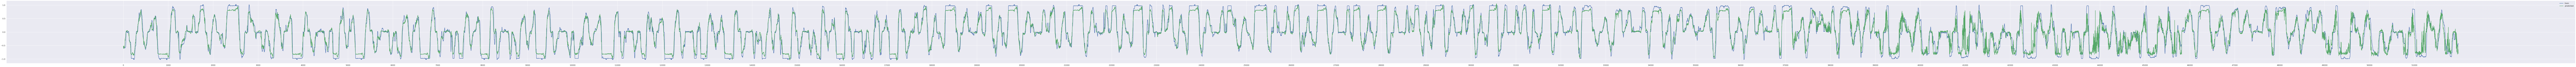

In [32]:
# visual actual vs predicted
plt.figure(figsize=(400,10))
plt.plot(y_train, label="train")
plt.plot(predicted[0, :,0], label="predicted")
plt.legend()
plt.xticks(np.arange(0,len(X_train), 1000))
plt.show()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


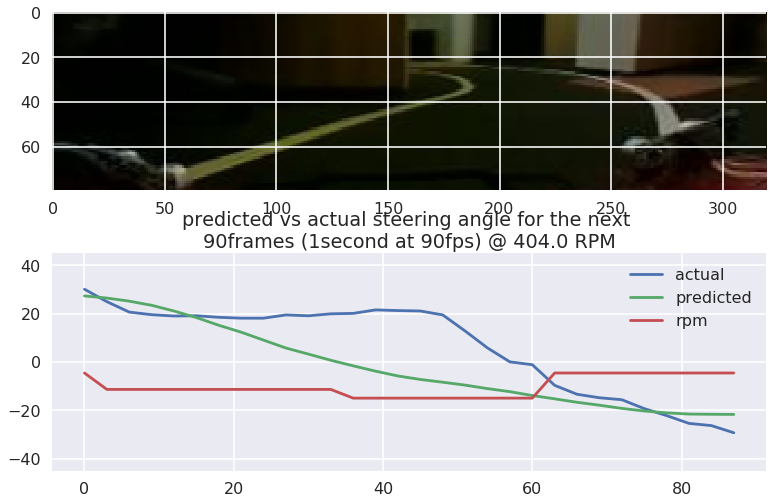

[[ 0.66800003]
 [ 0.55400001]
 [ 0.45800001]
 [ 0.43400002]
 [ 0.42199999]
 [ 0.424     ]
 [ 0.41000002]
 [ 0.402     ]
 [ 0.402     ]
 [ 0.43200001]
 [ 0.424     ]
 [ 0.44199999]
 [ 0.44599999]
 [ 0.47800001]
 [ 0.47199999]
 [ 0.46799999]
 [ 0.43200001]
 [ 0.28399997]
 [ 0.12799996]
 [-0.        ]
 [-0.02599996]
 [-0.21600003]
 [-0.298     ]
 [-0.32999997]
 [-0.348     ]
 [-0.42999997]
 [-0.49400007]
 [-0.56600003]
 [-0.58600006]
 [-0.65199992]]


In [54]:
#inference
frame = 39970


img = X_train[frame]
actual = yy_train[frame] * 45
predicted_angle = [x[frame][0] * 45 for x in predicted]



plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(np.arange(0,90,3),actual, label="actual")
plt.plot(np.arange(0,90,3),predicted_angle,  label="predicted")
plt.plot(np.arange(0,90,3),S_train[frame: frame + 90:3, 0] * 500 - 45, label="rpm")
plt.ylim((-45,45))
plt.legend()
plt.title("predicted vs actual steering angle for the next \n90frames (1second at 90fps) @ {} RPM".format(S_train[frame][0] * 5000))
plt.show()

print(yy_train[frame])